In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

# cluster functions
empty = [0]
point = [1,2]
pair_1 = [3,4]
pair_2 = [5,6,7]
pair_3 = [8,9,10,11]
pair_4 = [12,13,14,15]
triplet_1 = [16,17]
#triplet_2 = [18,19,20,21]

def select_cluster(df_corr, clusters):
    clus = []
    for i in clusters:
        clus = clus + i
    clus = np.array(clus)
    return df_corr.iloc[:,clus]

def regularize_dos(df_dos, grid_fine, smooth_width=0, log=False):
    df_dos_fine = pd.DataFrame(index=df_dos.index, columns=['dos_hse'])
    for i in df_dos.index:
        dos = df_dos.loc[i, "dos_hse"]
        grid_coarse = df_dos.loc[i, "energy_hse"]
        if smooth_width > 0:
            box = np.ones(smooth_width)/smooth_width
            dos = np.convolve(dos, box, mode='same')
        f = interpolate.interp1d(grid_coarse,dos)
        df_dos_fine.loc[i,"dos_hse"] = f(grid_fine)
    if log:
        _dos_log = df_dos_fine.copy()
        for i in df_dos_fine.index:
            _dos_log.loc[i,'dos_hse'] = np.log(df_dos_fine.loc[i,'dos_hse']+0.1)
        df_dos_fine = _dos_log
    return df_dos_fine

def weight(df_dos, gap_max, w_exp):
    w = np.exp((gap_max-df_dos.gap.values.astype(float))/w_exp)
    return w

def calc_model(corr,x, w):
    xx = np.concatenate(x.values)
    ndos = len(xx)/len(corr)
    xx = xx.reshape(len(corr), int(ndos))
    ridge = linear_model.Ridge(fit_intercept=False)
    alphas = np.logspace(-5, 1, 10)
    params = [{'alpha': alphas}]
    model = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=3, refit=True, return_train_score= True)
    model.fit(corr.values, xx)
    return model

def match(df_dos, df_corr):
    overlap = list(set(df_dos['configname']).intersection(set(df_corr['configname'])))
    if len(overlap) < len(df_dos['configname']):
        raise ValueError('DOS and correlation data inconsistent.')
    df = pd.DataFrame()
    for i in df_dos['configname']:
        df = df.append(df_corr[df_corr['configname'] == i])
    return df

def main(mat, clusters, dos, gap_th=0.2, w_exp=0.1, align=False, verbose=False):
    global grid_fine, df_dos_fine, ref_ind
    smooth_width = 5 # the box width used to smooth the density of states
    is_log = False
    #grid_fine = np.arange(2,8,0.02) # grid for the selected energy range
    # read corr matrix and electronic densities
    df_corr = pd.read_csv('corr_{0}.csv'.format(mat), delim_whitespace=True)
    df_dos = pd.read_hdf('pdos_{0}.h5'.format(mat))
    # semiconductors only
    # drop metallic structures
    #
    df_dos = df_dos[df_dos['configname'].str.contains('SCEL1|SCEL2|SCEL3')]
    #
    semi = df_dos[(df_dos.gap > gap_th)].index
    df_dos = df_dos.loc[semi]
    df_corr = match(df_dos, df_corr)
    #
    assert (df_dos.index == df_corr.index).all()
    #ref_ind = df_dos.gap.idxmax()
    if mat == 'czts':
        ref_ind = 1
    else:
        ref_ind = 0
    vbm = df_dos.loc[ref_ind, 'vbm']
    # interpolate the dos on a specific regular mesh
    #df_dos_fine = regularize_dos(df_dos, grid_fine, smooth_width=smooth_width, log=is_log)
    #
    # alignment wrt Cu-semicore
    if (mat == 'czts') | (mat == 'czts_occ'):
        dos_list = ['dos', 'dos_cu', 'dos_sn', 'dos_s', 'dos_zn']
    else:
        dos_list = ['dos', 'dos_cu', 'dos_sn', 'dos_s', 'dos_cd']
    if align:
        ref_level = df_dos.loc[ref_ind, 'ref']
        delta_ref = df_dos['ref'] - ref_level
        for dos_type in dos_list:
            df_dos[dos_type] -= delta_ref
    # keep original mesh and data
    df_dos_fine = df_dos
    grid_fine = df_dos_fine.iloc[0]['energy'] - vbm
    # return the index of energy grid at the vbm
    ind_vbm = np.argmax(grid_fine > 0)
    # normalize the DOS
    for dos_type in dos_list:
        df_dos[dos_type] = df_dos[dos_type] / df_dos['natom']
    train = df_corr
    df_corr_train = train.loc[:,"corr(0)":"corr(17)"]
    df_dos_train = df_dos_fine.loc[train.index]
    dos_train = df_dos_train.loc[:,dos].sum(axis=1)
    #
    corr_train = select_cluster(df_corr_train, clusters)
    #
    w = weight(df_dos.loc[train.index],df_dos.loc[ref_ind,'gap'],w_exp)
    if verbose:
        display(corr_train)
        display(dos_train)
    model = calc_model(corr_train, dos_train, w)
    dos_train_pred = model.predict(corr_train)
    
    print(model.best_estimator_.coef_[ind_vbm:ind_vbm+10].sum(axis=0))
    # test the cluster expansion on the test set
    # plot the real dos (gray) and the predicted dos (red)
    plt.rcParams['figure.figsize'] = [10, 8]
    if verbose:
        fig, ax1 = plt.subplots(1)
        for i in range(len(dos_train)):
            ax1.plot(grid_fine, dos_train.iloc[i]+0.5*i, color='gray')
            ax1.plot(grid_fine, dos_train_pred[i]+0.5*i, color='r')
        ax1.set_xlim([-1,2])
        ax1.set_ylim([0,5])
        ax1.set_title("Cluster expanded DOS: Test set")
    # plot the eci vs energy
    fig, ax2 = plt.subplots(1)
    for i in range(len(model.best_estimator_.coef_[0,:])):
        ax2.plot(grid_fine, model.best_estimator_.coef_[:,i], label=i)
    for pred_iloc in range(len(dos_train)):
        if (dos_train.iloc[pred_iloc] - dos_train.loc[ref_ind]).max() == 0:
            break
    ax2.plot(grid_fine, dos_train_pred[pred_iloc], 'k-')
    ax2.plot(grid_fine, dos_train.loc[ref_ind], 'k--')
    ax2.set_ylabel("Effective cluster DOS")
    ax2.text(0.4, 0.8, mat.upper()+" "+" + ".join(dos).upper(), transform=ax2.transAxes, fontsize=12)
    ax2.set_xlim([-1,2])
    ax2.set_ylim([-0.2,1.])
    ax2.legend()
    #
    return model

def ecdos(mat,clusters,dos,model,write=False):
    # plot DOS vs Temperature using the correlation matrix from MC simulations
    df_mc = pd.read_csv('mc_{0}.csv'.format(mat), delim_whitespace=True)
    df_mc = df_mc[df_mc['T'] <= 1000].reset_index()
    corr_str = []
    for i in range(18):
        corr_str.append("<corr({0:})>".format(i))
    df_corr_mc = df_mc.loc[:,corr_str]
    corr_mc = select_cluster(df_corr_mc, clusters)
    corr_mc = corr_mc.set_index(df_mc['T']).sort_index(ascending=False) # use temperature as index
    dos_mc_pred = model.predict(corr_mc)
    # cluster decomposed contribution
    _eci = model.best_estimator_.coef_.T
    _corr = corr_mc.values
    _ecdos = np.zeros(len(_corr.T))
    corr_fraction = np.zeros((len(model.best_estimator_.coef_),)+corr_mc.shape)
    for i in range(len(corr_fraction)): # energy
        for j in range(len(_corr)):     # temperature
            for k in range(len(_corr.T)): # corr
                _ecdos[k] = _corr[j,k]*_eci[k,i]
            corr_fraction[i,j] = _ecdos
    #
    plt.rcParams['figure.figsize'] = [10, 6]
    fig, (ax) = plt.subplots(1)
    norm = mpl.colors.Normalize(vmin=corr_mc.index.min(), vmax = corr_mc.index.max())
    cmap = mpl.cm.get_cmap('jet')
    c = [cmap(norm(temp)) for temp in corr_mc.index]
    ax.set_xlim([-1,2])
    ax.set_ylim([-0.2,1.])
    grid_ = grid_fine
    for i in range(len(dos_mc_pred)):
        ax.plot(grid_, dos_mc_pred[i], color=c[i])
    cax, _ = mpl.colorbar.make_axes(ax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    # plot the kesterite reference dos
    ax.plot(grid_, df_dos_fine.loc[ref_ind, "dos"], '--', c='k', label='reference at LT')
    ax.set_xlabel(r'$E-E_{VBM}$ (eV)')
    ax.set_ylabel(r'Temperature-dependent DOS')
    ax.text(0.4, 0.8, mat.upper()+" "+" + ".join(dos).upper(), transform=ax.transAxes, fontsize=12)
    ax.legend()
    #
    plt.rcParams['figure.figsize'] = [12, 8]
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    for i in range(len(dos_mc_pred)):
        ax1.plot(grid_, corr_fraction[:,i,1:3].sum(axis=1)*2, color=c[i])
        ax2.plot(grid_, corr_fraction[:,i,3:5].sum(axis=1)*2, color=c[i])
        ax3.plot(grid_, corr_fraction[:,i,5:8].sum(axis=1)*2, color=c[i])
        ax4.plot(grid_, corr_fraction[:,i,8:].sum(axis=1)*2, color=c[i])
    for _ax in [ax1,ax2,ax3,ax4]:
        _ax.set_xlim([-1,2])
        _ax.set_ylim([-0.2,1.])
        _ax.text(0.4,0.8,'x2',fontsize=11)
        #cax, _ = mpl.colorbar.make_axes(_ax)
        #cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    if write:
        plt.savefig('{0}_dos.pdf'.format(mat))
    return corr_fraction, corr_mc

[ 0.39505973 -0.10094207 -0.19317559  0.29758905 -0.00231819 -0.07898178
  0.11311439  0.17127977 -0.29295267 -0.29295267]
[ 0.08393282 -0.03830725 -0.00731832  0.01676338 -0.0148974   0.00890029
  0.00301834 -0.00444372  0.01303142  0.01303142]


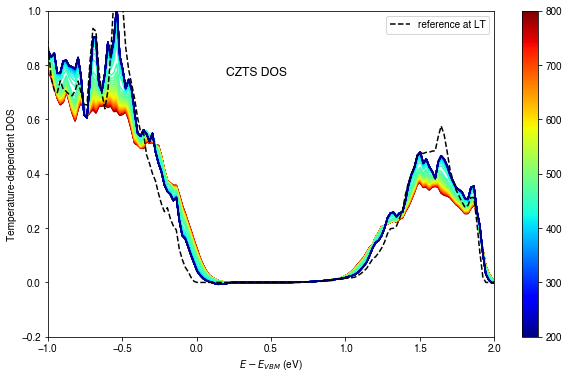

In [6]:
mat = 'czts'
w_exp = 10
gap_th = 0.3
align = True
verbose = False
clusters = [empty, point, pair_1, pair_2, triplet_1] 
dos_cuzn = ['dos_cu', 'dos_zn']; dos_cu = ['dos_cu']; dos_zn = ['dos_zn']
dos_tot = ['dos']; dos_s = ['dos_s']; dos_sn = ['dos_sn']

for dos in [dos_tot]:
    model_czts = main(mat=mat, clusters=clusters, dos=dos, gap_th=gap_th, w_exp=w_exp, align=align, verbose=verbose)
    corr_fraction, corr_mc = ecdos(mat=mat, clusters=clusters, dos=dos, model=model_czts, write=False)

In [38]:
model_czts.cv_results_.

{'mean_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_alpha': masked_array(data=[1e-05, 4.641588833612782e-05, 0.00021544346900318823,
                    0.001, 0.004641588833612777, 0.021544346900318822, 0.1,
                    0.46415888336127725, 2.154434690031882, 10.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 1e-05},
  {'alpha': 4.641588833612782e-05},
  {'alpha': 0.00021544346900318823},
  {'alpha': 0.001},
  {'alpha': 0.004641588833612777},
  {'alpha': 0.021544346900318822},
  {'alpha': 0.1},
  {'alpha': 0.46415888336127725},
  {'alpha': 2.154434690031882},
  {'alpha': 10.0}],
 'split0_test_score': array([-0.14, -0

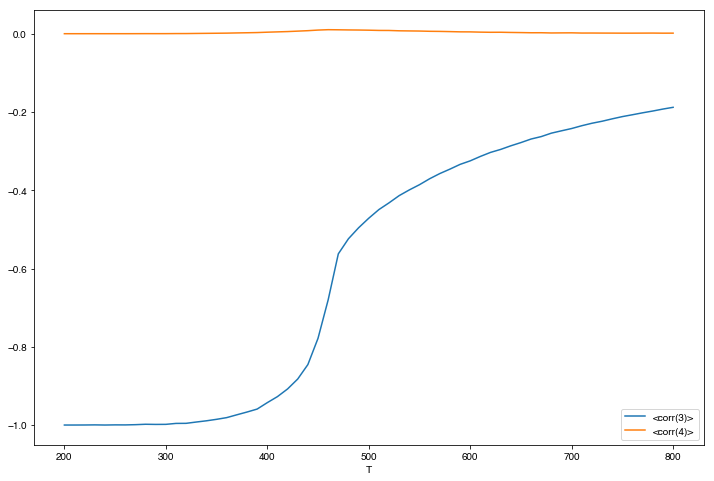

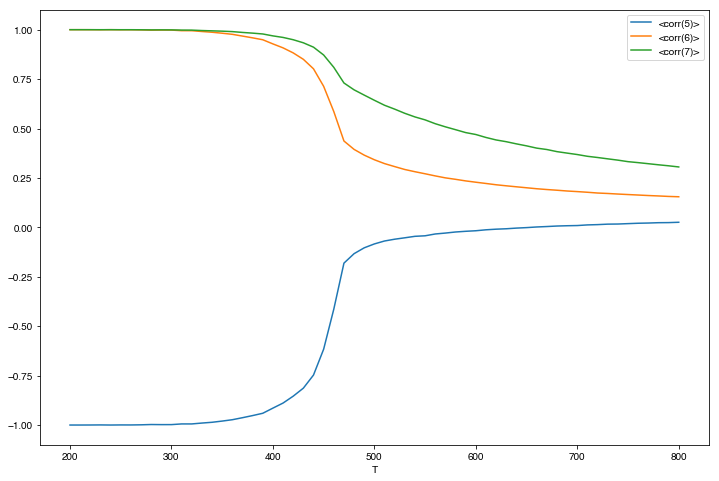

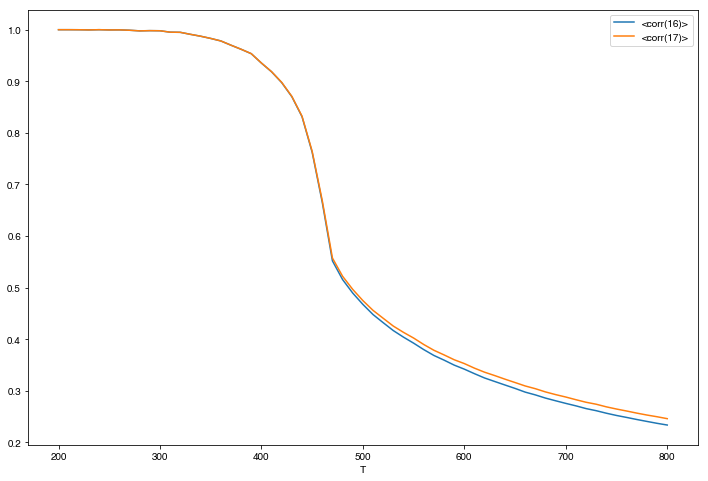

In [13]:
corr_mc.loc[:,"<corr(1)>":"<corr(2)>"].plot()
corr_mc.loc[:,"<corr(3)>":"<corr(4)>"].plot()
corr_mc.loc[:,"<corr(5)>":"<corr(7)>"].plot()
corr_mc.loc[:,"<corr(16)>":"<corr(17)>"].plot()

[ 0.58 -0.14 -0.3   0.44  0.07 -0.17  0.12 -0.07 -0.31 -0.15]


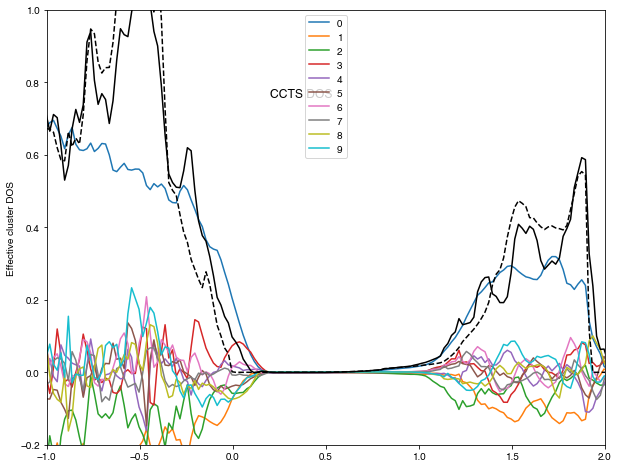

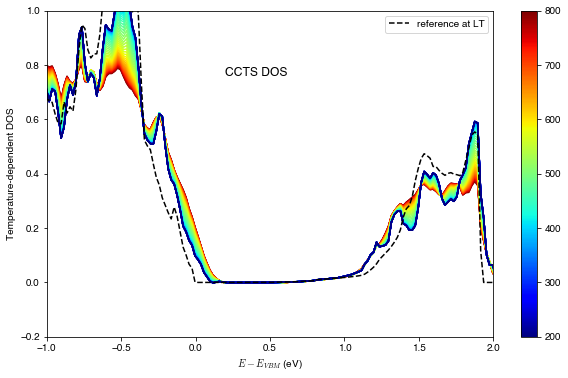

In [5]:
mat = 'ccts'
w_exp = 10
gap_th = 0.2
align = True
verbose = False
clusters = [empty, point, pair_1, pair_2, triplet_1] 
dos_cucd = ['dos_cu', 'dos_cd']; dos_cu = ['dos_cu']; dos_cd = ['dos_cd']
dos_tot = ['dos']; dos_s = ['dos_s']; dos_sn = ['dos_sn']

for dos in [dos_tot]:
    reg_ccts = main(mat=mat, clusters=clusters, dos=dos, gap_th=gap_th, w_exp=w_exp, align=align, verbose=verbose)
    corr_fraction, corr_mc = ecdos(mat=mat, clusters=clusters, dos=dos, reg=reg_ccts, write=False)

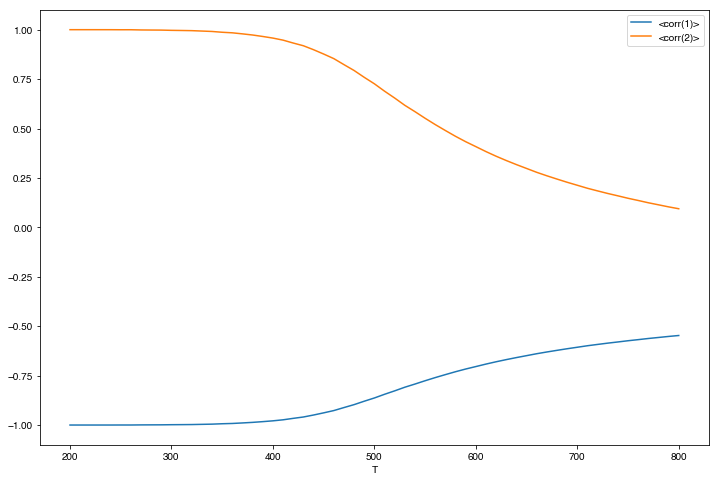

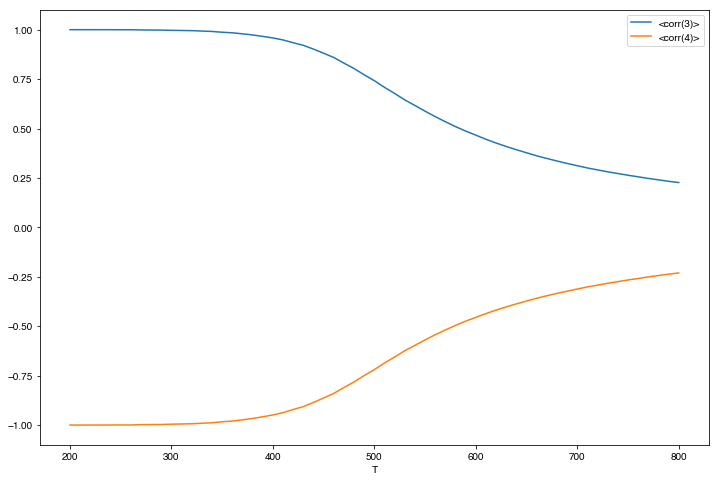

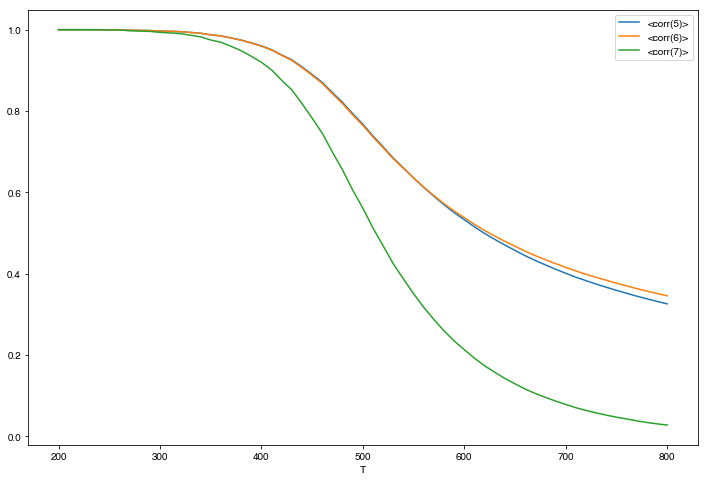

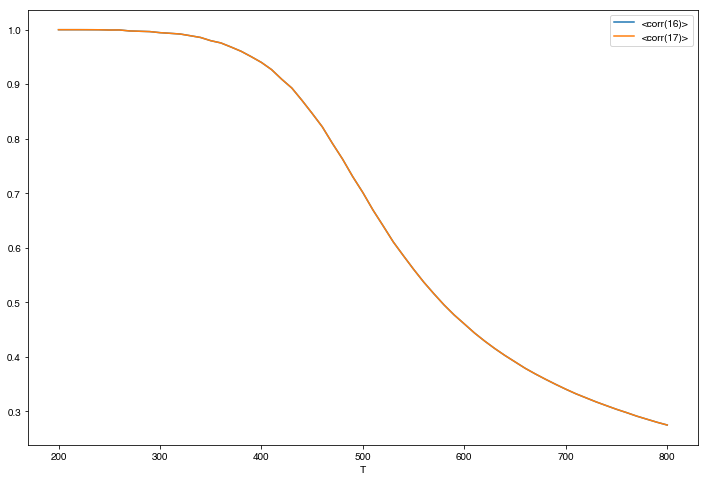

In [6]:
corr_mc.loc[:,"<corr(1)>":"<corr(2)>"].plot()
corr_mc.loc[:,"<corr(3)>":"<corr(4)>"].plot()
corr_mc.loc[:,"<corr(5)>":"<corr(7)>"].plot()
corr_mc.loc[:,"<corr(16)>":"<corr(17)>"].plot()

[ 0.42 -0.1  -0.22  0.31  0.01 -0.07  0.12  0.15 -0.33 -0.33]


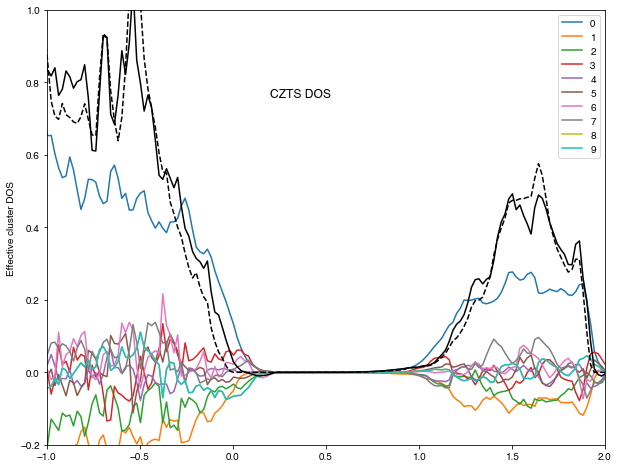

In [8]:
mat = 'czts'
w_exp = 10
gap_th = 0.3
align = True
verbose = False
clusters = [empty, point, pair_1, pair_2, triplet_1] 
dos_cuzn = ['dos_cu', 'dos_zn']; dos_cu = ['dos_cu']; dos_zn = ['dos_zn']
dos_tot = ['dos']; dos_s = ['dos_s']; dos_sn = ['dos_sn']

for dos in [dos_tot]:
    reg_czts = main(mat=mat, clusters=clusters, dos=dos, gap_th=gap_th, w_exp=w_exp, align=align, verbose=verbose)
    #corr_fraction, corr_mc = ecdos(mat=mat, clusters=clusters, dos=dos, reg=reg_czts, write=False)